# Unsupervised learning on Weblogs

> This Notebook is part of a study on applied machine learning for quick incident response, so please cite the "Machine Learning Approach to Quick Incident Response" article published in COMM2020 proceedings -- "2020 13th International Conference on Communications (COMM)".

## 0. Quick start

### Dataset description

After parsing and properly labeling a small amount of the original web access log, we constructed a feature dataset with the following characteristics:

-	unusual_hours;
-	has_bad_rep;
-	has_bad_string;
-	method;
-	version;
-   status;
-	log_len_uri; 
-	log_bytes;
-	scripting_useragent.

In [1]:
import pandas as pd
df = pd.read_csv("../input/1k-access/dataset_1ktrain_noscore.csv")
df.describe()

,unusual_hours,has_bad_rep,has_bad_string,method,version,status,log_len_uri,log_bytes,scripting_useragent
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1009.0
mean,0.263627,0.475719,0.383548,0.206145,0.139742,0.800793,1.667278,3.764500,0.0
std,0.440818,0.682589,1.776323,0.693738,0.491290,1.323985,0.487364,1.316039,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.491362,2.900913,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.716003,4.055799,0.0
75%,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,1.875061,4.435733,0.0
max,1.000000,3.000000,25.000000,5.000000,4.000000,3.000000,2.941014,8.761358,0.0


### Evaluation of the dataset

Using cross-validation with ten folds method, we evaluated the efficiency of different machine learning algorithms on the resulting dataset.
To provide us with a quick start, we conducted the experiments with default parameters in Weka 3.8.4.

Algorithm | Precision |	MAE	 | Obs.
---|---|---|---
ZeroR|50.05 %|0.50|baseline
OneR|87.22 %|0.13|used just log_bytes to make the prediction
NaiveBayes|84.84 %|0.17| 
SVM|88.21 %|0.12| 	
J48|93.77 %|0.09| 
RandomForest|95.54 %|0.08|most accurate on extracted features

### Exploratory data analysis (EDA)

EDA is an approach to dataset analysis in which the data is summarized using its main characteristics, often in visual form. We observe that the suspicious events are not easily separable from the safe ones, highlighted by the two different colors corresponding to the safe and suspicious labels.

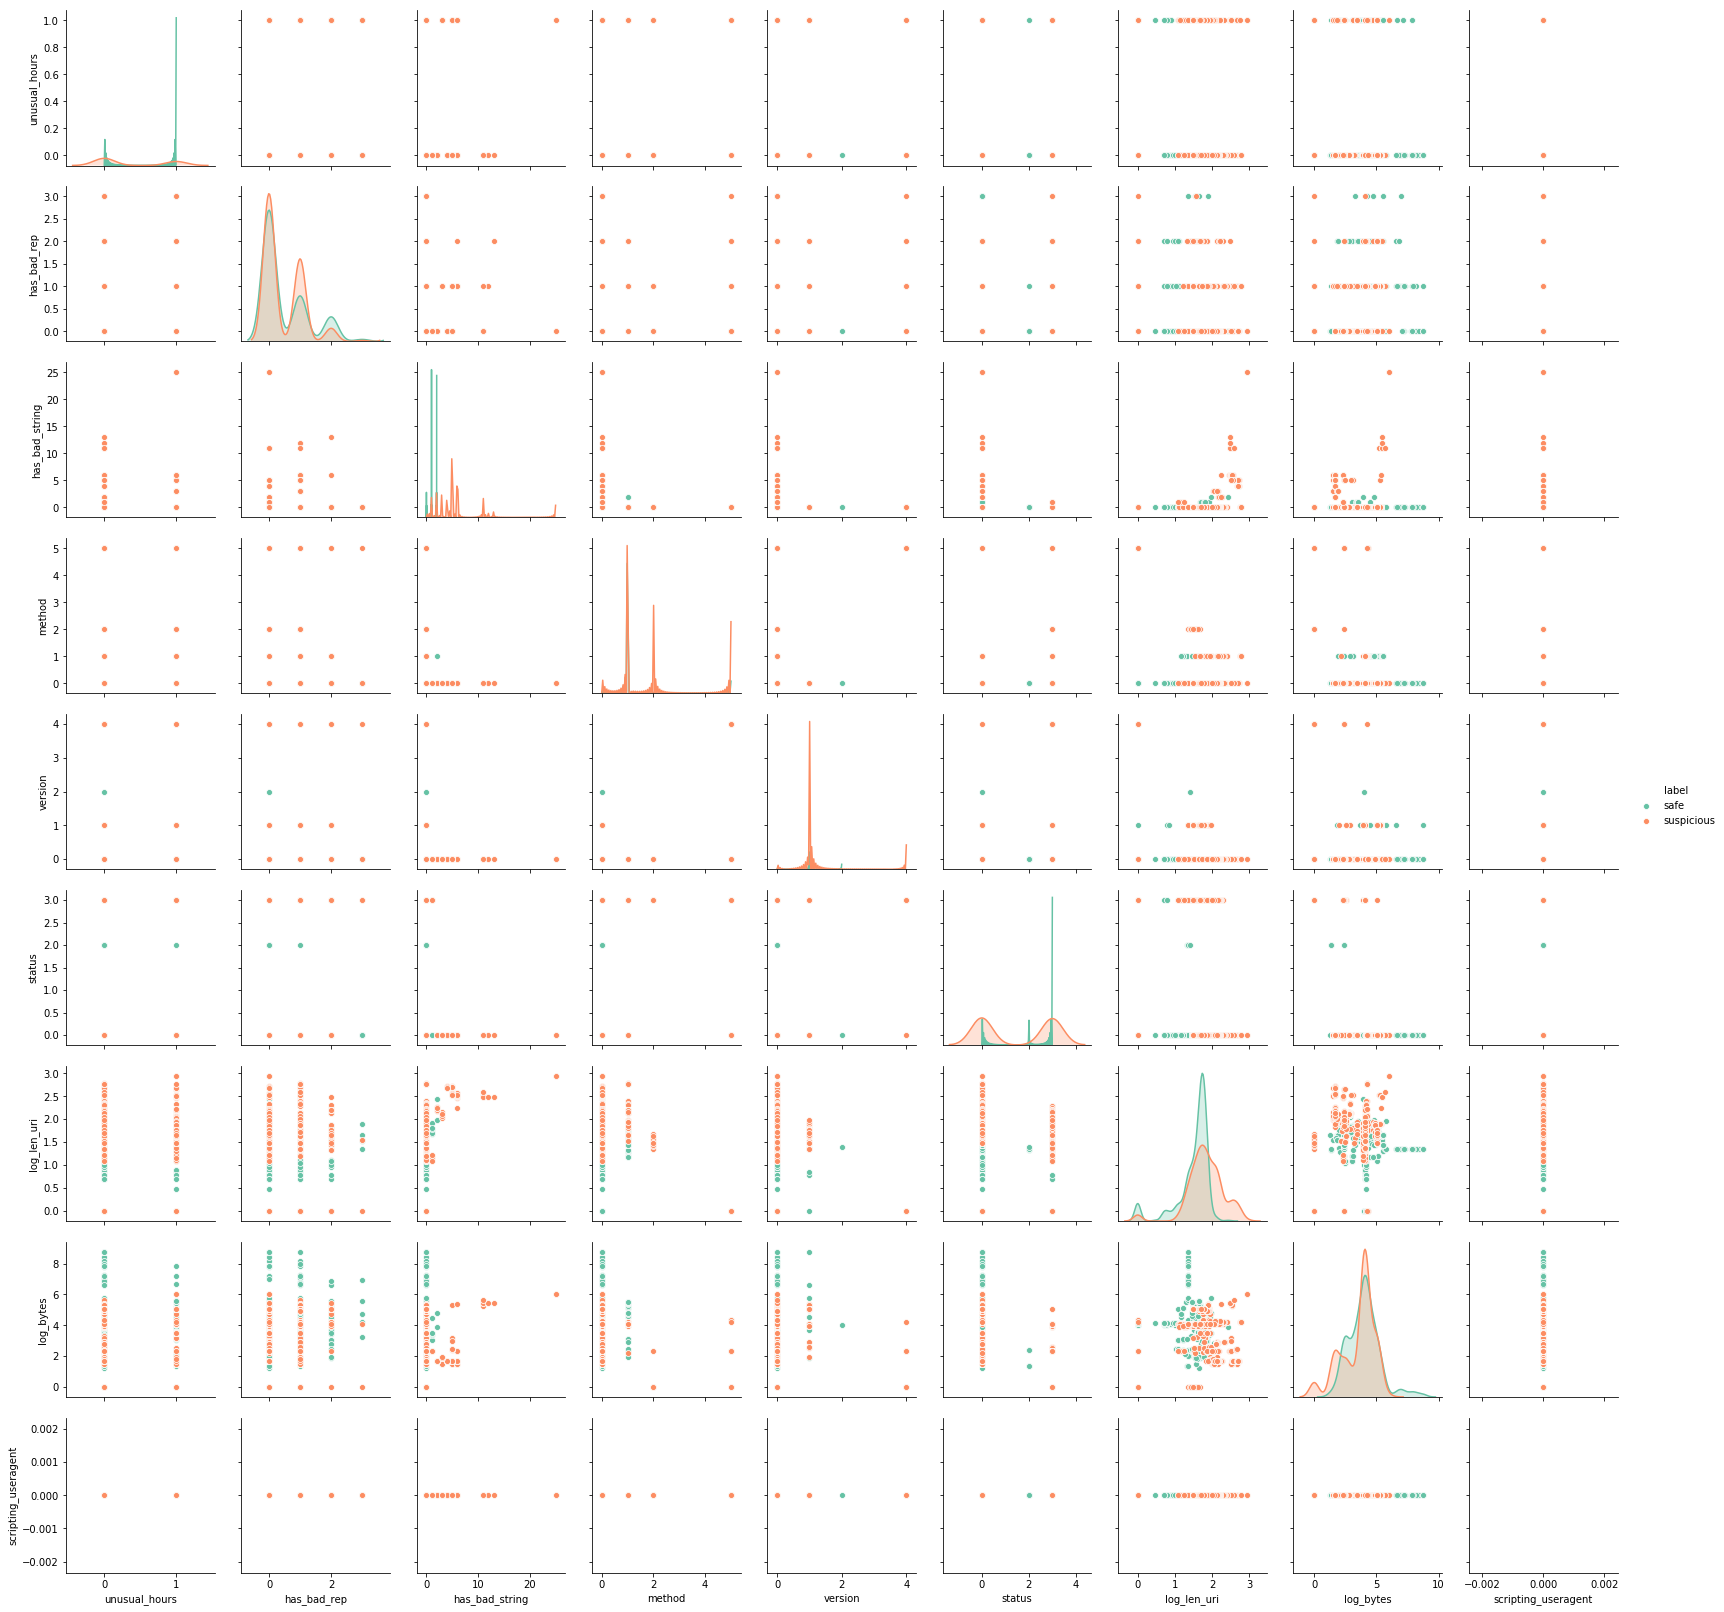

In [2]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(data=df,hue="label",palette="Set2")
plt.show()

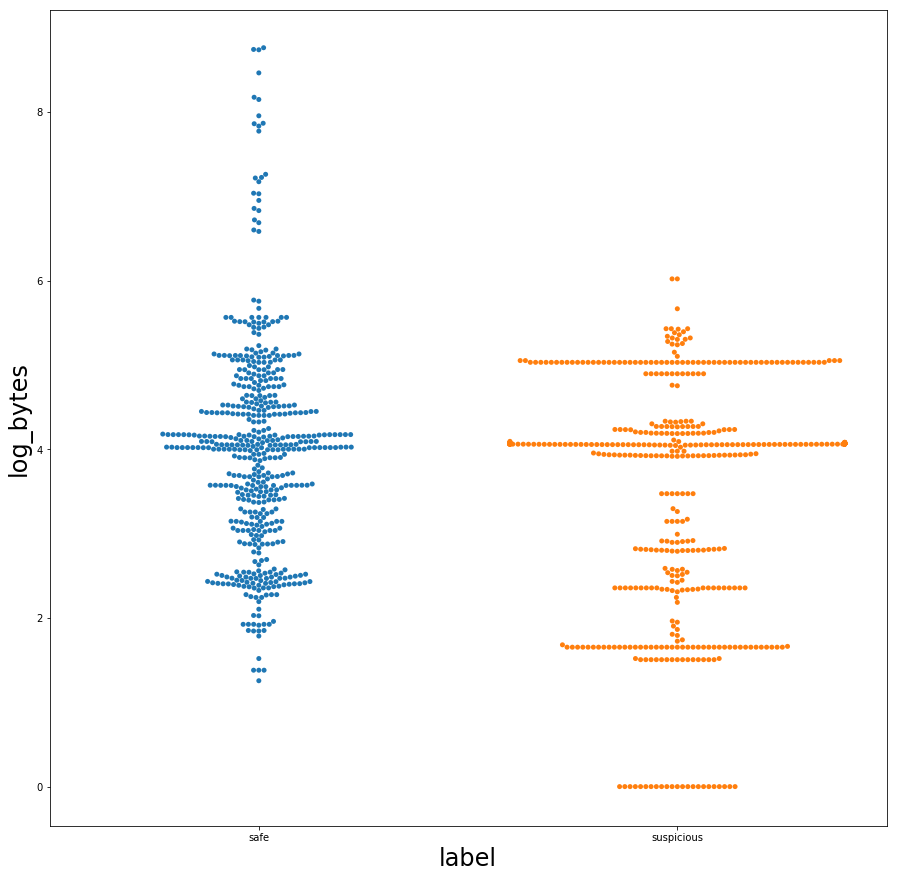

In [3]:
plt.figure(figsize=(15,15))
plt.xlabel('Event type',fontsize=24)
plt.ylabel('Response size',fontsize=24)
sns.swarmplot(x='label', y='log_bytes', data=df)
plt.show()

## 1. Testing K-Means Clustering 

### Adjusting the dataset for unsupervised learning
For unsupervised learning, we do not need the labels for the feature vectors. We are not dropping the scripting_useragent column, even though the value is always 0 since, in the new data, we could have other values. This characteristic can be quickly dropped in the code below as needed. We also encode the labels as 0 for safe items and 1 for suspicious.

In [4]:
X = df.drop(['label'], axis=1)
mapping = {'safe': 0, 'suspicious': 1}
y = df['label'].replace(mapping)

### Finding the ideal number of clusters

Ideally, the dataset should be grouped around two cluster centers and should be easily separated into the two categories, safe and suspicious. If we use methods for ideal cluster number determination, like the ones presented below, we observe that the theoretical number of clusters is way beyond two.
To demonstrate, we use SciKit-Learn implementation with most of the parameters as default. Even though we already know that we should differentiate two clusters, it is an outstanding practice to check the ideal amount with algorithms like: [1,2,3,4]
- The elbow method looks at the total With-in-Sum-of-Squares (WSS) as a function of the number of clusters. We should choose a number of clusters so that the addition of one more will not significantly improve the total WSS;
- The gap statistic method compares the total within intra-cluster variation for different k’s with their expected values under the null reference distribution of the data. The optimal k will be the value that maximizes the gap statistic (e.g., that yields the most significant gap statistic). (R. Tibshirani, G. Walther, and T. Hastie, Standford University, 2001);
- The Silhouette method computes the average silhouette of observations for different values of k. The optimal k maximizes the average silhouette (Kaufman and Rousseeuw 1990).

In [5]:
##Calculation 
%matplotlib inline
import time
import hashlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import silhouette_score

def optimalK(data, nrefs=3, maxClusters=20):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

sil = []
kmax = 20
wcss = []

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(X)
  labels = kmeans.labels_
  sil.append(silhouette_score(X, labels, metric = 'euclidean'))

for k in range(1,kmax):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
k, gapdf = optimalK(X, nrefs=5)
#print('Optimal k (GAP): ', k)

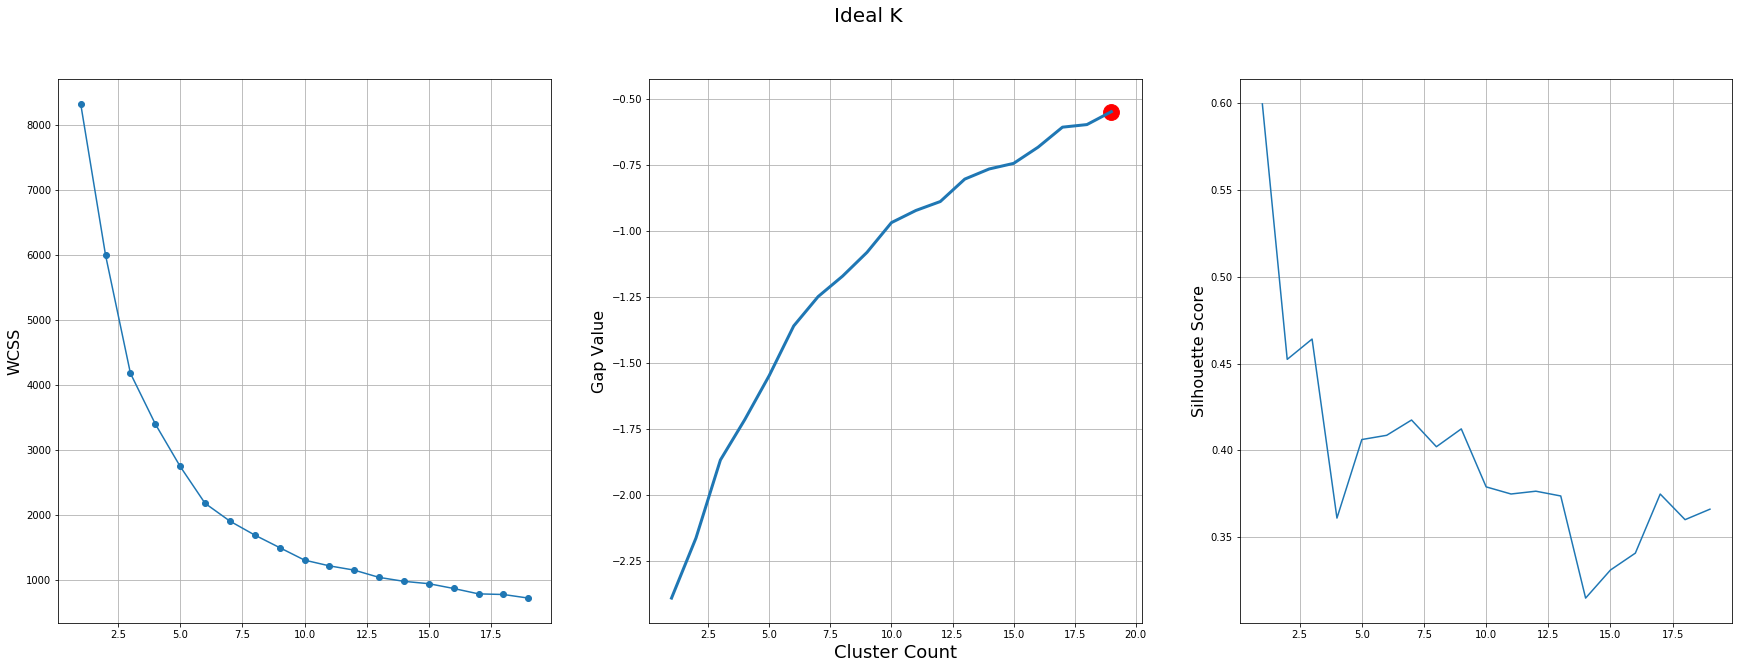

In [6]:
##Visualisation 
plt.figure(figsize=(30,10))
plt.suptitle('Ideal K',fontsize=20)


plt.subplot(1,3,1)
plt.plot(range(1,20),wcss,"-o")
plt.grid(True)
plt.ylabel('WCSS',fontsize=16)

plt.subplot(1,3,2)
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.grid(True)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.xlabel('Cluster Count',fontsize=18)
plt.ylabel('Gap Value',fontsize=16)

plt.subplot(1,3,3)
plt.plot(range(1,20),sil)
plt.grid(True)
plt.ylabel("Silhouette Score",fontsize=16)

plt.show()

**As seen above, the results obtained from the elbow and gap methods are not promising, since they return very high values for k. Nevertheless, the third evaluation is encouraging since the Silhouette Score is at its maximum when k is 3. To summarise, none of the tests gave us the desired k = 2. This result is an expected one since there are situations when the extracted features have very close values for both safe and suspicious events. The next step should be to enhance somehow the dataset so that the clusters could be more separable.**

## 2. Dataset enrichment

As in hybrid classifiers, we intend to use additional supervised algorithms to improve the overall results.
First, we tried Linear Regression and evaluated the dataset based on the following primary metrics:
- Mean Absolute Error (MAE) – the average error;
- Mean Squared Error (MSE) – more significant errors are punished;
- Root Mean Squared Error (RMSE) – it is recommended that it should be used as the primary metric to interpret your model.

In [7]:
##Linear Regression
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance
from sklearn.metrics import precision_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
from sklearn import metrics
import joblib

features = df.drop(['label'], axis=1)

train = df.sample(n=900, replace=True, random_state=1)
test = df.drop(train.index)

X_train = train.drop(['label'], axis=1)
mapping = {'safe': 0, 'suspicious': 1}
y_train = train['label'].replace(mapping)

X_test = test.drop(['label'], axis=1)
mapping = {'safe': 0, 'suspicious': 1}
y_test = test['label'].replace(mapping)

regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm

#To retrieve the intercept:
print('Intercept: %.8f' % regressor.intercept_)
#For retrieving the slope:
#print(regressor.coef_)

# save the model to disk
filename = 'LR.model'
joblib.dump(regressor, filename)

y_pred = regressor.predict(X_test).round()

y_test = np.array(list(y_test))
y_pred = np.array(y_pred)

count=0

for i in range(len(y_test)):
    if y_test.flatten()[i] !=  round(y_pred.flatten()[i]):
        count+=1
     
precision = precision_score(y_test, y_pred, average='micro')
print('Precision: %.2f' % float(precision*100), "%")

#print(count)
#print(len(y_test))

#dataset2 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
#dataset2

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
coeffecients = pd.DataFrame(regressor.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
#coeffecients

Intercept: -0.45363860
Precision: 88.38 %
MAE: 0.11864406779661017
MSE: 0.1234866828087167
RMSE: 0.3514067199253832


**The precision on the observed known data has improved significantly. Let us try adding one more feature based on the original ones by employing the Multi-layer Perceptron algorithm.**

In [8]:
##Multi-layer Perceptron 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score
import joblib

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)
#print([coef.shape for coef in clf.coefs_])
#print(clf.coefs_)

y_pred = clf.predict(X_test)

precision = precision_score(y_test, y_pred, average='micro')
print('Precision: %.2f' % float(precision*100), "%")

features["mlp_pred"] = (clf.predict(features[["unusual_hours", 
                                             "has_bad_rep",
                                             "has_bad_string", 
                                             "method", 
                                             "version", 
                                             "status", 
                                             "log_len_uri", 
                                             "log_bytes", 
                                             "scripting_useragent"]]))

# save the model to disk
filename = 'MLP.model'
joblib.dump(clf, filename)

Precision: 92.74 %


['MLP.model']

In [9]:
features["lr_pred"] = (0.13688273 * df["unusual_hours"] 
                     + 0.03655747 * df["has_bad_rep"] 
                     + 0.04017277 * df["has_bad_string"] 
                     - 0.05029479 * df["method"] 
                     + 0.34400104 * df["version"] 
                     + 0.20885592 * df["status"] 
                     + 0.41214625 * df["log_len_uri"]
                     - 0.00410462 * df["log_bytes"]
                     + 0.00000000 * df["scripting_useragent"]
                     - 0.45363860)

df["lr_pred"] = (0.13688273 * df["unusual_hours"] 
                     + 0.03655747 * df["has_bad_rep"] 
                     + 0.04017277 * df["has_bad_string"] 
                     - 0.05029479 * df["method"] 
                     + 0.34400104 * df["version"] 
                     + 0.20885592 * df["status"] 
                     + 0.41214625 * df["log_len_uri"]
                     - 0.00410462 * df["log_bytes"]
                     + 0.00000000 * df["scripting_useragent"]
                     - 0.45363860)

df["mlp_pred"] = (clf.predict(df[["unusual_hours", 
                                    "has_bad_rep",
                                    "has_bad_string", 
                                    "method", 
                                    "version", 
                                    "status", 
                                    "log_len_uri", 
                                    "log_bytes", 
                                    "scripting_useragent"]]))

## 3. Testing unsupervised learning on the new dataset

We have plotted the graphical representation based on the most significant features (log_bytes and has_bad_strings) for k between 1 and 4, as suggested by the CfsSubsetEval algorithm [5].

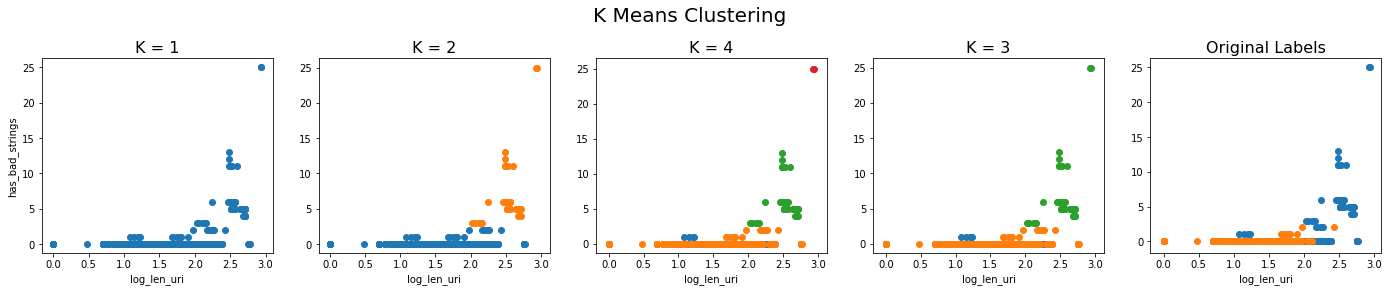

In [10]:
plt.figure(figsize=(24,4))

plt.suptitle("K Means Clustering",fontsize=20)

plt.subplot(1,5,1)
plt.title("K = 1",fontsize=16)
plt.xlabel("log_len_uri")
plt.ylabel("has_bad_strings")
plt.scatter(features.log_len_uri,features.has_bad_string)


plt.subplot(1,5,2)
plt.title("K = 2",fontsize=16)
plt.xlabel("log_len_uri")
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
features["labels"] = kmeans.fit_predict(features)
plt.scatter(features.log_len_uri[features.labels == 0],features.has_bad_string[features.labels == 0])
plt.scatter(features.log_len_uri[features.labels == 1],features.has_bad_string[features.labels == 1])

# I drop labels since we only want to use features.
features.drop(["labels"],axis=1,inplace=True)

plt.subplot(1,5,4)
plt.title("K = 3",fontsize=16)
plt.xlabel("log_len_uri")
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
features["labels"] = kmeans.fit_predict(features)
plt.scatter(features.log_len_uri[features.labels == 0],features.has_bad_string[features.labels == 0])
plt.scatter(features.log_len_uri[features.labels == 1],features.has_bad_string[features.labels == 1])
plt.scatter(features.log_len_uri[features.labels == 2],features.has_bad_string[features.labels == 2])

# I drop labels since we only want to use features.
features.drop(["labels"],axis=1,inplace=True)

plt.subplot(1,5,3)
plt.title("K = 4",fontsize=16)
plt.xlabel("log_len_uri")
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
features["labels"] = kmeans.fit_predict(features)
plt.scatter(features.log_len_uri[features.labels == 0],features.has_bad_string[features.labels == 0])
plt.scatter(features.log_len_uri[features.labels == 1],features.has_bad_string[features.labels == 1])
plt.scatter(features.log_len_uri[features.labels == 2],features.has_bad_string[features.labels == 2])
plt.scatter(features.log_len_uri[features.labels == 3],features.has_bad_string[features.labels == 3])

# I drop labels since we only want to use features.
features.drop(["labels"],axis=1,inplace=True)

plt.subplot(1,5,5)
plt.title("Original Labels",fontsize=16)
plt.xlabel("log_len_uri")
plt.scatter(df.log_len_uri[df.label == "suspicious"],df.has_bad_string[df.label == "suspicious"])
plt.scatter(df.log_len_uri[df.label == "safe"],df.has_bad_string[df.label == "safe"])

plt.subplots_adjust(top=0.8)
plt.show()

**We observe that for k = 2, the graphical representation is quite similar to the original labeling, but we still do not observe separable clusters.**

**Let us also try the hierarchical clustering method. We are looking for the longest vertical line without any perpendicular matching lines (euclidian distances). We observed three significant groups in the graphical representation of the hierarchical clustering method on our data, so the ideal number of labels would be three.**

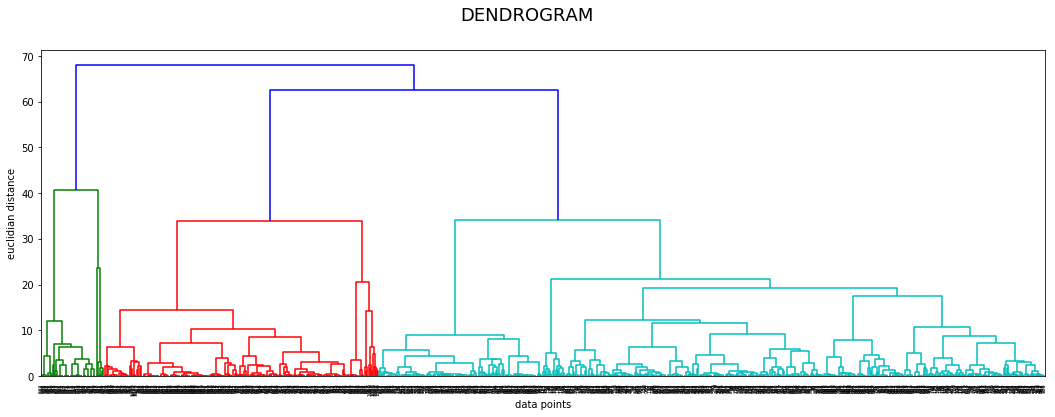

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

merg = linkage(features,method="ward")

plt.figure(figsize=(18,6))
dendrogram(merg, leaf_rotation=90)
plt.xlabel("data points")
plt.ylabel("euclidian distance")

plt.suptitle("DENDROGRAM",fontsize=18)
plt.show()

**This result is a more realistic depiction of our data since the dataset contains elements with almost identical feature vectors from distinct classes.**

## 4. Evaluation and comparison of the results

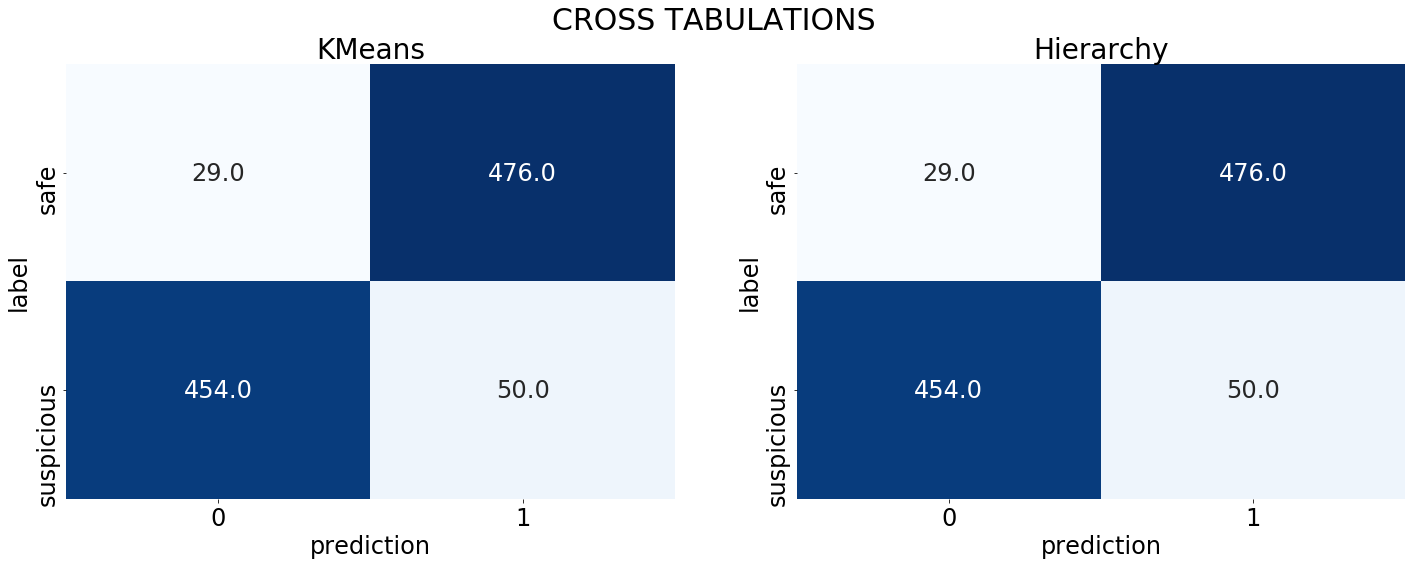

In [12]:
from sklearn.cluster import AgglomerativeClustering

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
features["labels"] = kmeans.fit_predict(features[['lr_pred', 'mlp_pred']])

# cross tabulation table for kmeans
df1 = pd.DataFrame({'prediction':features['labels'] ,"label":df['label'] })
ct1 = pd.crosstab(df1['label'],df1['prediction'])


# hierarchy
hc_cluster = AgglomerativeClustering(n_clusters=2)
hc_predict = hc_cluster.fit_predict(features[['lr_pred', 'mlp_pred']])

# cross tabulation table for Hierarchy
df2 = pd.DataFrame({'prediction':hc_predict,"label":df['label']})
ct2 = pd.crosstab(df2['label'],df2['prediction'])


plt.figure(figsize=(24,8))
plt.suptitle("CROSS TABULATIONS",fontsize=30)
ax = plt.subplot(1,2,1)
label_font = {'size':'24'}
ax.set_xlabel('Prediction', fontdict=label_font);
ax.set_ylabel('Label', fontdict=label_font);
ax.tick_params(axis='both', which='major', labelsize=24)  # Adjust to fit

plt.title("KMeans", fontsize=28)
sns.heatmap(ct1,annot=True,cbar=False, fmt=".1f", cmap="Blues", annot_kws={'size':24})#, square=True)

ay = plt.subplot(1,2,2)

ay.set_xlabel('Prediction', fontdict=label_font);
ay.set_ylabel('Label', fontdict=label_font);
ay.tick_params(axis='both', which='major', labelsize=24)  # Adjust to fit
plt.title("Hierarchy", fontsize=28)
sns.heatmap(ct2,annot=True,cbar=False, fmt=".1f", cmap="Blues", annot_kws={'size':24})#, square=True)

plt.show()

The routine below will evaluate the 10k extracted dataset, from the original web access log. You can use the extractor script to <extract> features from the rest of the web logs.

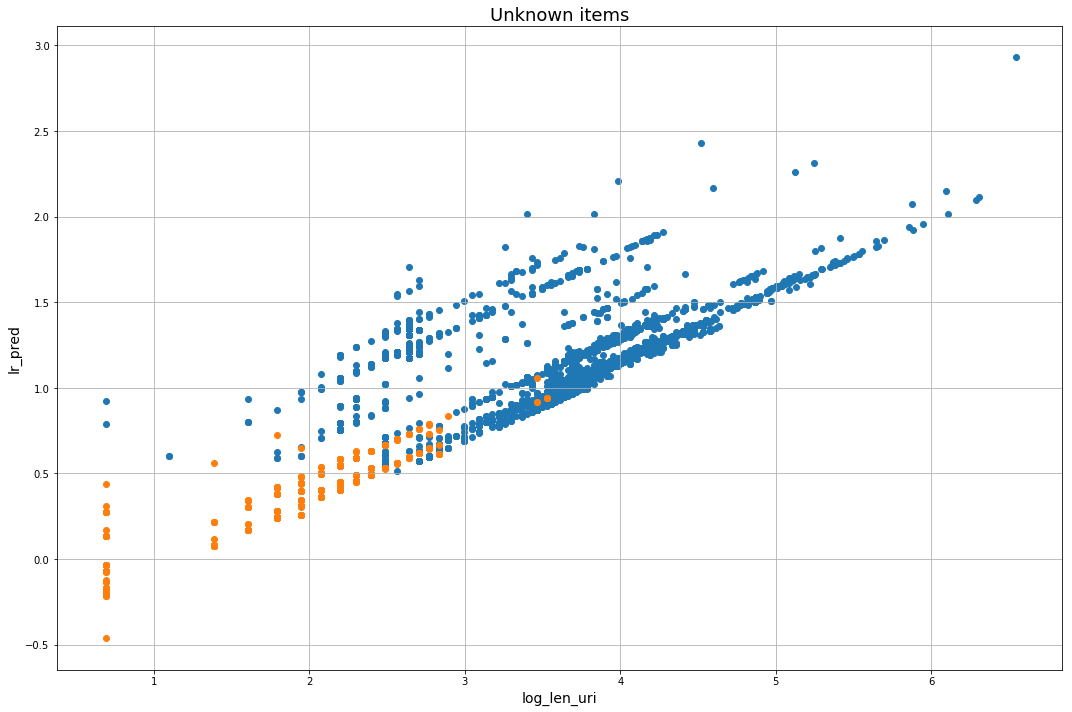

Saved csv!


In [13]:
import pandas as pd
import joblib

d10k = pd.read_csv("../input/10k-access/dataset_web_10K.csv", delimiter=',')

# load the models from disk
MLP_model = joblib.load('MLP.model')
LR_model = joblib.load('LR.model')

#print(d10k[['scripting_useragent']])
d10k["mlp_pred"] = (MLP_model.predict(d10k[["unusual_hours", 
                                                 "has_bad_rep",
                                                 "has_bad_string", 
                                                 "method", 
                                                 "version", 
                                                 "status", 
                                                 "log_len_uri", 
                                                 "log_bytes", 
                                                 "scripting_useragent"]]))

d10k["lr_pred"] = (LR_model.predict(d10k[["unusual_hours", 
                                                 "has_bad_rep",
                                                 "has_bad_string", 
                                                 "method", 
                                                 "version", 
                                                 "status", 
                                                 "log_len_uri", 
                                                 "log_bytes", 
                                                 "scripting_useragent"]]))

kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=300, n_init=10, random_state=0)
d10k["labels"] = kmeans.fit_predict(d10k[['lr_pred', 'mlp_pred']])

plt.figure(figsize=(15,10))
plt.title("Unknown items", fontsize=18)
plt.grid(True)
plt.scatter(d10k.log_len_uri[d10k.labels == 0],d10k.lr_pred[d10k.labels == 0])
plt.scatter(d10k.log_len_uri[d10k.labels == 1],d10k.lr_pred[d10k.labels == 1])
plt.xlabel("log_len_uri",fontsize=14)
plt.ylabel("lr_pred",fontsize=14)
plt.tight_layout()
plt.show()

d10k.to_csv (r'export_labeled_df.csv', index = False, header=True)
print("Saved csv!")

# Conclusion

### The features extracted from the weblogs are not enough for clustering, so we need to implement supervised learning algorithms to extract data form labeled entries. 

### As future work, the analysis process applied to requests can be improved, switching from a string match method to a principal component analysis (PCA) and entropy calculation.

# Sources

[1] Satsawat Natakarnkitkul, Get the Optimal K in K-Means Clustering, https://medium.com/towards-artificial-intelligence/get-the-optimal-k-in-k-means-clustering-d45b5b8a4315

[2] Robert Tibshirani, Guenther Walther and Trevor Hastie, Estimating the number of clusters in a data set via the gap statistic, https://statweb.stanford.edu/~gwalther/gap

[3] https://www.programcreek.com/python/example/97803/tqdm.tqdm_notebook

[4] Khyati Mahendru, How to Determine the Optimal K for K-Means?, https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

[5] M. A. Hall, Correlation-based Feature Subset Selection for Machine Learning. Hamilton, New Zealand (1998).

[6] Efe Ergun, Unsupervised Learning on Iris, https://www.kaggle.com/efeergun96/unsupervised-learning-on-iris